In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random
import pandas as pd

from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
#from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [3]:
import pandas as pd

In [4]:
path2csv = './dataset/NaturalHumanFaceImagesforEmotionRecognition/label.csv'
df = pd.read_csv(path2csv)
df.tail()

,img_path,label
5553,./dataset/NaturalHumanFaceImagesforEmotionReco...,surprise
5554,./dataset/NaturalHumanFaceImagesforEmotionReco...,surprise
5555,./dataset/NaturalHumanFaceImagesforEmotionReco...,surprise
5556,./dataset/NaturalHumanFaceImagesforEmotionReco...,surprise
5557,./dataset/NaturalHumanFaceImagesforEmotionReco...,surprise


In [5]:
mapping = {'happiness':0, 'anger':1, 'surprise':2, 'sadness':3, 'fear':4, 'neutrality':5, 'disgust':6, 'contempt':7}
temp_list = list(df['label'].unique())
df.insert(2, 'class',df.label.map(lambda x: temp_list.index(x)))
df.head()

,img_path,label,class
0,./dataset/NaturalHumanFaceImagesforEmotionReco...,anger,0
1,./dataset/NaturalHumanFaceImagesforEmotionReco...,anger,0
2,./dataset/NaturalHumanFaceImagesforEmotionReco...,anger,0
3,./dataset/NaturalHumanFaceImagesforEmotionReco...,anger,0
4,./dataset/NaturalHumanFaceImagesforEmotionReco...,anger,0


In [6]:
import torchvision.models as models
model = models.resnet18(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, df['class'].nunique())

In [7]:
model.load_state_dict(torch.load('./weights/NaturalHumanFaceImagesforEmotionRecognition.pth', map_location=torch.device('cpu')))
model.eval()
#cam_extractor = SmoothGradCAMpp(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.metadata.iloc[idx, 0]
        if not os.path.isfile(img_name):
            print(img_name, idx)
        image = Image.open(img_name).convert("RGB")
        label = self.metadata.iloc[idx, 2]
        str_label = self.metadata.iloc[idx, 1]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label, img_name
# inputs, gt, image_path

In [9]:
im_size = 224
train_dataset = CustomDataset(df,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomRotation(45),
                                               transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [10]:
batch_size = 1
eval_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)

In [11]:
indexs = []
images = []
def test(model, test_loader):
    with torch.no_grad():
        for i, data in enumerate(eval_loader):
            with torch.no_grad():
                inputs, gt, image_path = data
                inputs, gt = inputs.to(device), gt.to(device)
                
                outputs = model(inputs)
                
                _, preds = torch.max(outputs, 1)

                if gt == preds:
                    images.append(image_path)
                    indexs.append(i)

In [12]:
device = torch.device('cuda' if not torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
test(model, eval_loader)

In [14]:
len(images)

2395

In [15]:
cam_extractor = SmoothGradCAMpp(model)

In [16]:
str(images[0])

"('./dataset/NaturalHumanFaceImagesforEmotionRecognition/happiness/images - 2020-11-06T184529.760_face.png',)"

In [19]:
import random

show_imgs = random.sample(images, 15)
print(show_imgs)

[('./dataset/NaturalHumanFaceImagesforEmotionRecognition/fear/9k_ (8)_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/anger/images - 2020-11-06T004126.327_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/happiness/images - 2020-11-06T193953.523_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/happiness/images - 2020-11-06T000521.833_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/neutrality/images - 2020-11-06T184422.548_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/fear/images - 2020-11-06T184305.015_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/fear/images - 2020-11-06T190127.013_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/neutrality/9996431843_32b67a3426_b_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/happiness/images - 2020-11-06T192301.240_face.png',), ('./dataset/NaturalHumanFaceImagesforEmotionRecognition/

[CLASS] :  fear


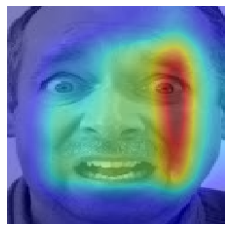

[CLASS] :  anger


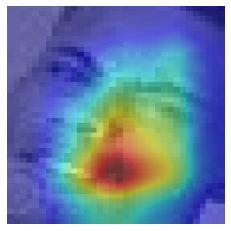

[CLASS] :  happiness


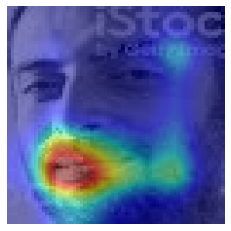

[CLASS] :  happiness


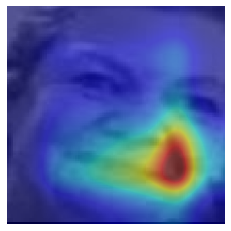

[CLASS] :  neutrality


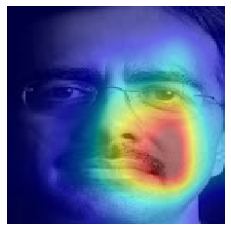

[CLASS] :  fear


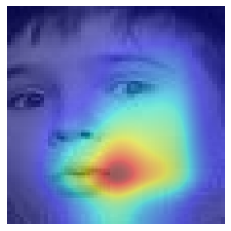

[CLASS] :  fear


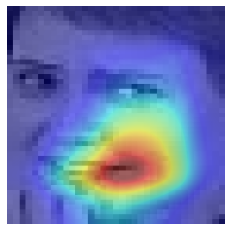

[CLASS] :  neutrality


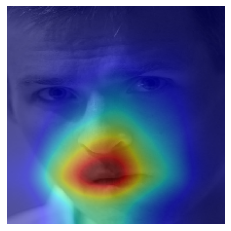

[CLASS] :  happiness


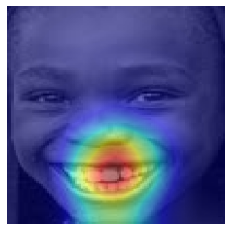

[CLASS] :  happiness


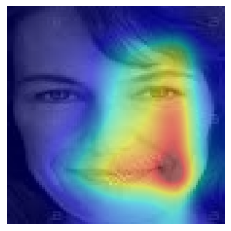

[CLASS] :  fear


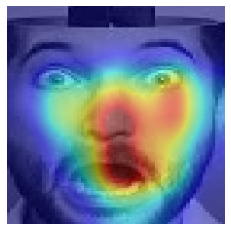

[CLASS] :  happiness


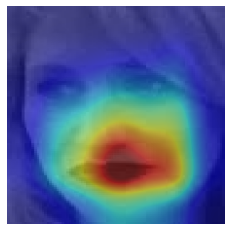

[CLASS] :  anger


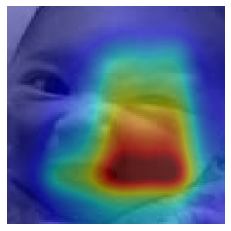

[CLASS] :  happiness


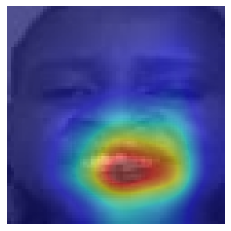

[CLASS] :  anger


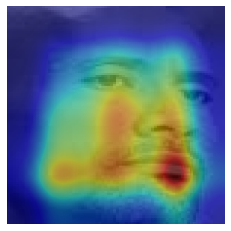

In [39]:
# torchvision.transforms.ToTensor
tf_toTensor = transforms.ToTensor() 

for i, image in enumerate(show_imgs):
    print("[CLASS] : ", image[0].split("/")[-2])
    #img = read_image(''.join(image))
    img = Image.open(image[0]).convert("RGB")
    input_tensor = tf_toTensor(img)

    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(to_pil_image(input_tensor), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    plt.imshow(result); plt.axis('off'); plt.show()